# Piano per lo svolgimento

In [18]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
from pylab import rcParams
rcParams["font.size"] = 12
rcParams['figure.figsize'] = (16,4)

Populating the interactive namespace from numpy and matplotlib


## Dataset: IBM stock values from 1962 to 2018

In [3]:
series = pd.Series.from_csv('ibm_daily_1962-2018.csv', sep=',',header=0)

/usr/local/lib/python2.7/dist-packages/pandas/core/series.py:3724: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


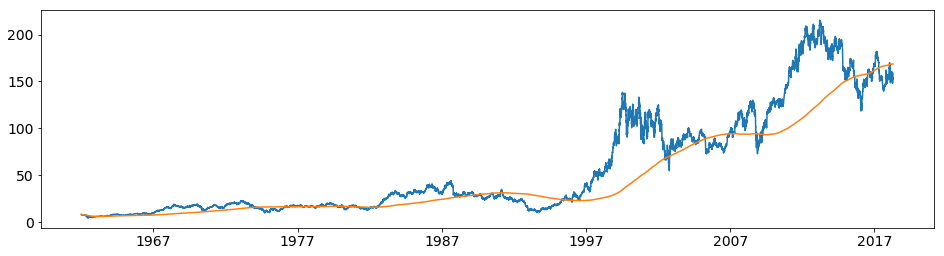

In [6]:
plt.plot(series)
plt.plot(series.rolling(window=2000, min_periods=1).mean())

## Time series da cui partire
Due casi: con noise e senza noise

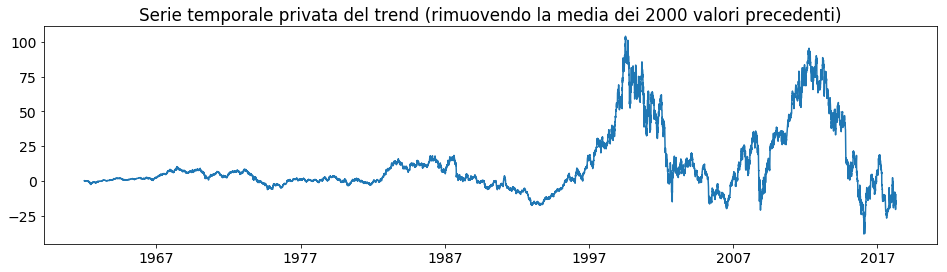

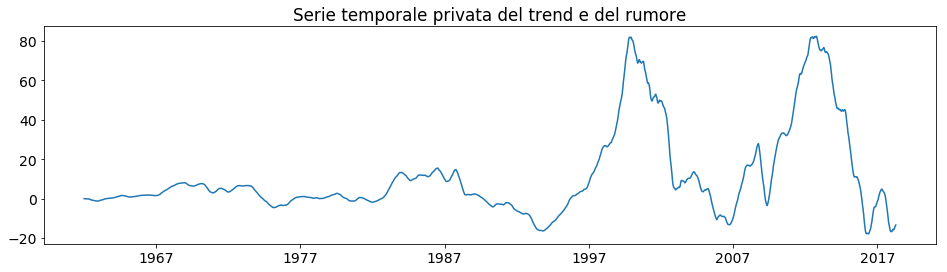

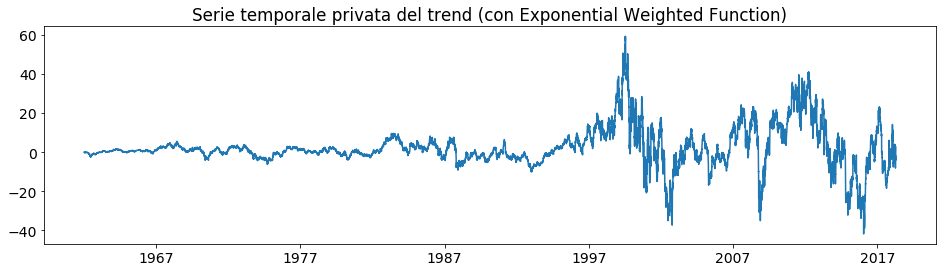

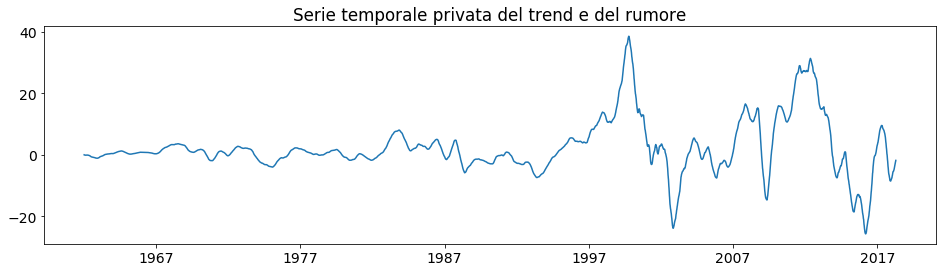

In [7]:
linear_trend = series.rolling(window=2000, min_periods=1).mean()
untrended = series - linear_trend

series_untr = pd.Series(untrended, series.index)
plt.title('Serie temporale privata del trend (rimuovendo la media dei 2000 valori precedenti)')
plt.plot(series_untr)


plt.figure()
untr_no_noise = series_untr.rolling(window=150, min_periods=1).mean()
plt.title('Serie temporale privata del trend e del rumore')
plt.plot(untr_no_noise)

plt.figure()
exp_decay_series = pd.Series(series - series.ewm(halflife=150).mean(), series.index)
plt.title('Serie temporale privata del trend (con Exponential Weighted Function)')
plt.plot(exp_decay_series)

plt.figure()
decay_no_noise = exp_decay_series.rolling(window=150, min_periods=1).mean()
plt.title('Serie temporale privata del trend e del rumore')
plt.plot(decay_no_noise)

## Split the time series into years (57 series) and normalize
and plot normalized time series

/usr/lib/python2.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  """


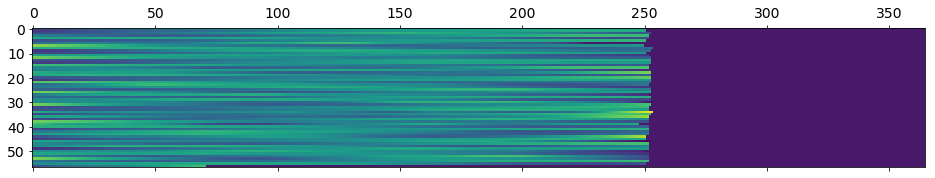

In [8]:
from pandas import TimeGrouper
from pandas import DataFrame

# TimeGrouper('Y') was not working
groups = decay_no_noise.groupby(TimeGrouper('A'))

mm = DataFrame()
series_dict = dict()
for name, group in groups:
    
    # Z-score normalization of the values
    norm_values = (group.values - mean(group.values)) / std(group.values)
    
    # Padding performed to have series of same length (365). 
    # Pad the time series with constant values (-3). 
    # IMPORTANT only for plotting the matrix
    pad_values = np.pad(norm_values,(0,365-len(norm_values)),'constant',constant_values=-3)
    
    year = "%s" % (name.year)
    mm[year] = pad_values
    series_dict[year] = norm_values
    
matshow(mm.T)

In [9]:
def make_series_of_same_size(dictionary, average_neigh=10):
    sizes = [x.shape[0] for x in dictionary.values()]
    max_size = max(sizes)
    
    vals = list(dictionary.values())
    
    for k in dictionary:
        s = dictionary[k]
        if s.shape[0] < max_size:
            start = s.shape[0]
            s_as_list = np.ndarray.tolist(s)
            while start < max_size:
                new_val = np.mean(s_as_list[-average_neigh:])
                s_as_list.append(new_val)
                start += 1
            dictionary[k] = np.asarray(s_as_list)
            
    return dictionary

#### Aggungere valori alle serie affinché siano tutte della stessa dimensione (per calcolare la distanza euclidea)

Text(0.5,1.05,'Heatmap delle serie')

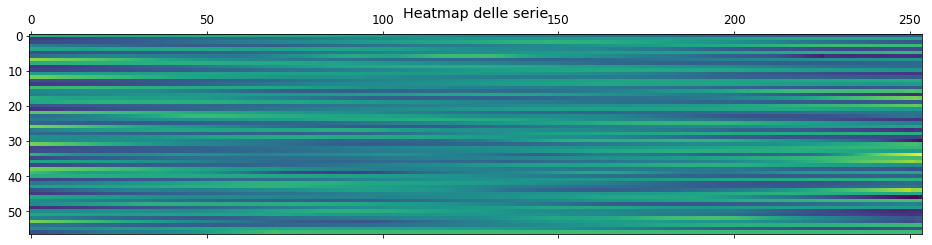

In [19]:
padded_series = make_series_of_same_size(series_dict)
matshow(pd.DataFrame.from_dict(padded_series).T, aspect='auto')
plt.title("Heatmap delle serie")
# Sembra che i valori alti siano rari nella parte centrale, 
# mentre a inizio anno e intorno al 250° giorno sono più comuni

# DTW

In [20]:

# Function for inferring the optimal path (general case)
# Starts from last cell and goes backwards...
def _traceback(D):
    import numpy as np
    i, j = np.array(D.shape) - 2
    p, q = [i], [j]
    while ((i > 0) or (j > 0)):
        tb = np.argmin((D[i, j], D[i, j+1], D[i+1, j]))
        if (tb == 0):
            i -= 1
            j -= 1
        elif (tb == 1):
            i -= 1
        else: # (tb == 2):
            j -= 1
        p.insert(0, i)
        q.insert(0, j)
    return np.array(p), np.array(q)

def dtw(x, y, dist, _traceback=_traceback):
    import numpy as np
    """
    Computes Dynamic Time Warping (DTW) of two sequences.

    :param array x: N1*M array
    :param array y: N2*M array
    :param func dist: distance used as cost measure

    Returns the minimum distance, the cost matrix, the accumulated cost matrix, and the wrap path.
    """
    assert len(x)
    assert len(y)
    r, c = len(x), len(y)
    
    # D0 = D1 = matrix of point-to-point costs
    D0 = np.zeros((r + 1, c + 1))
    D0[0, 1:] = np.inf
    D0[1:, 0] = np.inf
    D1 = D0[1:, 1:] # view (hide first column and first row)
    
    # Fill the point-to-point costs matrix
    for i in range(r):
        for j in range(c):
            D1[i, j] = dist(x[i], y[j])
            
    # C = matrix of optimal paths costs
    C = D1.copy()
    for i in range(r):
        for j in range(c):
            D1[i, j] += min(D0[i, j], D0[i, j+1], D0[i+1, j])
    
    # Infer the path from matrix C
    if len(x)==1:
        path = np.zeros(len(y)), range(len(y))  # special case 1
    elif len(y) == 1:
        path = range(len(x)), np.zeros(len(x))  # special case 2
    else:
        path = _traceback(D0)  # general case
        
    return D1[-1, -1], C, D1, path


In [21]:
def manhattan_dist(x,y):
    return sum(abs(x-y))

In [22]:
def distance(x,y):
    return abs(x-y)

In [23]:
def euclidean_dist(x,y):
    return np.sqrt(np.sum((x-y)**2))

In [24]:
def fake_euclid(x,y):
    return (np.sum((x-y)**2))

In [14]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
import pandas as pd
%pylab inline





from pylab import rcParams
rcParams['figure.figsize'] = (16,4)

Populating the interactive namespace from numpy and matplotlib


In [15]:
%%time

#import ipyparallel as ipp
from multiprocessing import Pool, cpu_count

################################################
#      CAUTION !!! CAN BE VERY SLOW !!!
################################################

# rc = ipp.Client()
pool = Pool(cpu_count())


years_list = series_dict.keys()


# # Compute upper half of matrix
# dd1 = [ [ (dtw(mm[years_list[x]],mm[years_list[y]],distance)[0] \
#            if y > x else -1)  \
#          for y in range(len(years_list)) ] 
#        for x in range(len(years_list)) ]

rows = len(years_list)
cols = len(years_list)
dd1 = -np.ones((rows, cols))
counter = 0

tmp = []

for x in range(rows):
    for y in range(cols):
        if y > x:
            args = [series_dict[years_list[x]],
                    series_dict[years_list[y]], 
                    distance]
            tmp.append( (pool.apply_async(dtw, args), x, y) )   
            counter = counter + 1
            if(counter == 5000):
                for (val, x, y) in tmp:
                    dd1[x,y] = np.sqrt(val.get(timeout=inf)[0])
                    #dd1[x,y] = val.get(timeout=inf)[0]
                tmp = []
                counter = 0
            
for (val, x, y) in tmp:
    dd1[x,y] = val.get(timeout=inf)[0]
    
pool.close()
pool.join()

# Copy values also to the lower half, exployting symmetry of the distance function
dd2 = [ [ (dd1[x][y] if y > x else dd1[y][x])  for y in range(len(years_list)) ] for x in range(len(years_list)) ]
# Finally, the diagonal
for i in range(len(years_list)):
    dd2[i][i] = 0.0

CPU times: user 1.39 s, sys: 1.36 s, total: 2.75 s
Wall time: 59.4 s


Text(0.5,1.05,'Matrice delle distanze (DTW)')

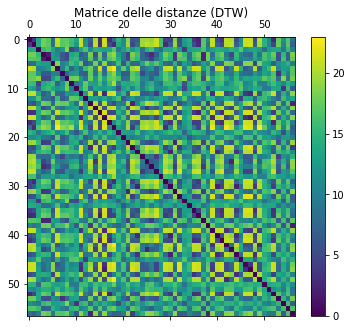

In [22]:
plt.figure(figsize=(6,5))
sqrt_dd2 = np.zeros(np.array(dd2).shape)
for i in range((sqrt_dd2.shape[0])):
    for j in range((sqrt_dd2.shape[1])):
        sqrt_dd2[i][j] = np.sqrt(dd2[i][j])
matshow(sqrt_dd2, interpolation=None, aspect='auto', fignum=1)
plt.colorbar()
plt.title("Matrice delle distanze (DTW)")

# Matrice delle distanze (Euclidean)

In [16]:
%%time

from multiprocessing import Pool, cpu_count

################################################
#      CAUTION !!! CAN BE VERY SLOW !!!
################################################

pool = Pool(cpu_count())


years_list = padded_series.keys()


# # Compute upper half of matrix
# dd1 = [ [ (dtw(mm[years_list[x]],mm[years_list[y]],distance)[0] \
#            if y > x else -1)  \
#          for y in range(len(years_list)) ] 
#        for x in range(len(years_list)) ]

rows = len(years_list)
cols = len(years_list)
dd1_euclidean = -np.ones((rows, cols))
counter = 0

tmp = []



for x in range(rows):
    for y in range(cols):
        if y > x:
            args = [padded_series[years_list[x]],
                    padded_series[years_list[y]]]
            # tmp.append( (pool.apply_async(np.linalg.norm, [args[0] - args[1]]), x, y) )   
            tmp.append( (pool.apply_async(euclidean_dist, [args[0], args[1]]), x, y) )   
            counter = counter + 1
            if(counter == 5000):
                for (val, x, y) in tmp:
                    dd1_euclidean[x,y] = val.get(timeout=inf)
                tmp = []
                counter = 0
            
for (val, x, y) in tmp:
    dd1_euclidean[x,y] = val.get(timeout=inf)
    
pool.close()
pool.join()

# Copy values also to the lower half, exployting symmetry of the distance function
dd2_euclidean = [ [ (dd1_euclidean[x][y] if y > x else dd1_euclidean[y][x])  \
                   for y in range(len(years_list)) ] \
                 for x in range(len(years_list)) ]
# Finally, the diagonal
for i in range(len(years_list)):
    dd2_euclidean[i][i] = 0.0

CPU times: user 365 ms, sys: 305 ms, total: 670 ms
Wall time: 604 ms


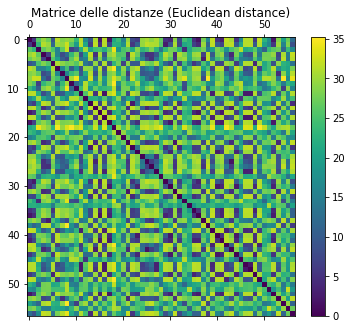

In [17]:
plt.figure(figsize=(6,5))
matshow(dd2_euclidean, interpolation=None, aspect='auto', fignum=1)
plt.colorbar()
plt.title("Matrice delle distanze (Euclidean distance)")

## Autocorrelation plot

Text(0.5,1,'Autocorrelation plot')

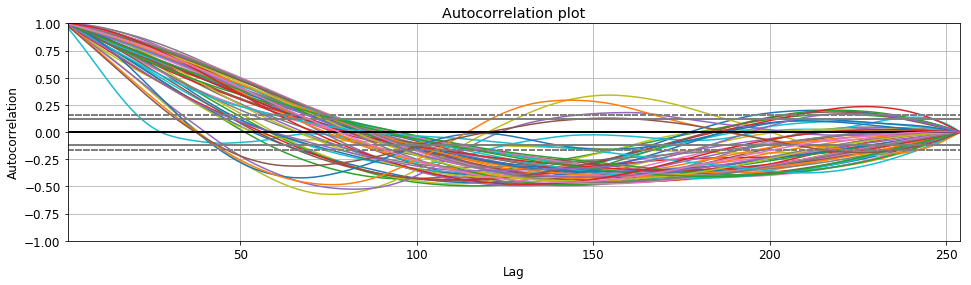

In [25]:
from pandas.plotting import autocorrelation_plot

# Disegna l'autocorrelation plot per ogni serie 
for ts in series_dict.values():
    autocorrelation_plot(ts)
plt.title("Autocorrelation plot")

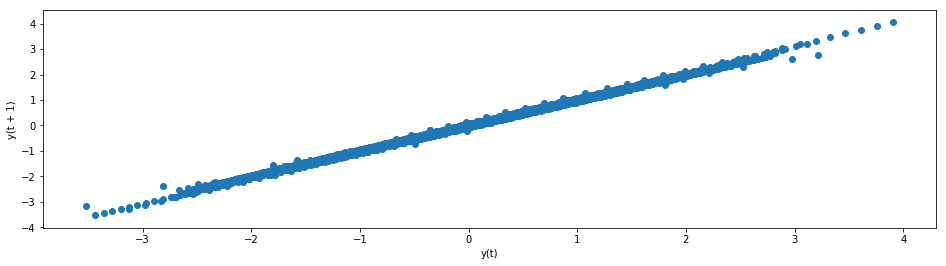

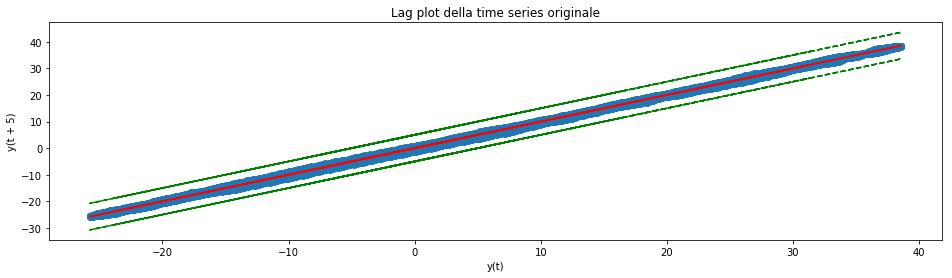

In [19]:
from pandas.plotting import lag_plot

# Disegna il lag plot per ogni serie 
for ts in series_dict.values():
    lag_plot(pd.Series.from_array(ts))
    
plt.figure()
lag_plot(decay_no_noise, lag=5)
plot(decay_no_noise, decay_no_noise, 'r-')
plot(decay_no_noise, decay_no_noise+5, 'g--')
plot(decay_no_noise, decay_no_noise-5, 'g--')
plt.title('Lag plot della time series originale')

## Stationarity

/usr/lib/python2.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: 'from_array' is deprecated and will be removed in a future version. Please use the pd.Series(..) constructor instead.
  if __name__ == '__main__':


Text(0.5,1,'Augmented Dickey-Fuller unit root test')

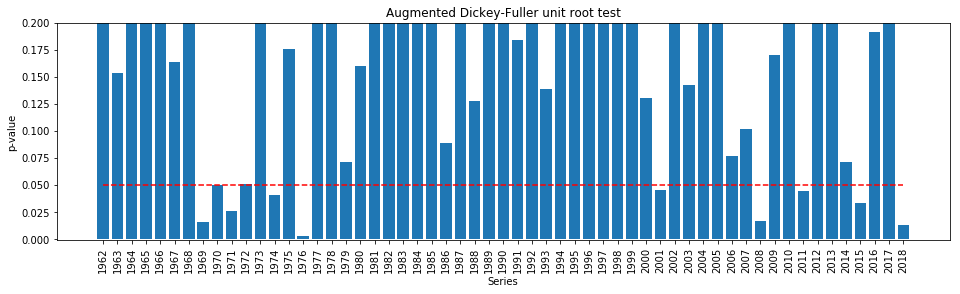

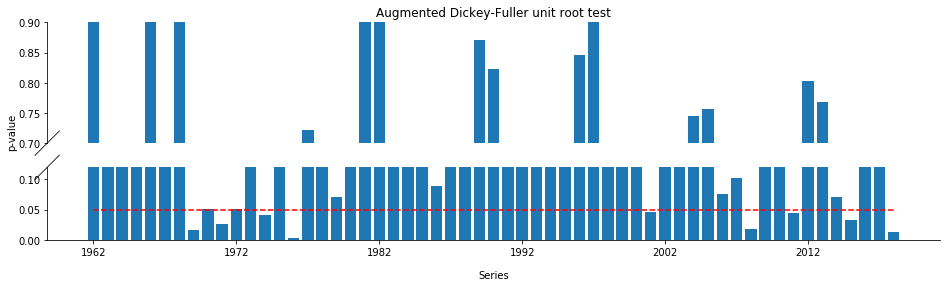

In [14]:
from statsmodels.tsa.stattools import adfuller
from collections import OrderedDict

vals = []

ordered_keys = sorted(series_dict.keys())

for i in range(len(ordered_keys)):
    result = adfuller(pd.Series.from_array(series_dict[ordered_keys[i]]))
#     print('ADF Statistic: %f' % result[0])
#     print('p-value: %f  (%s)' % (result[1], '< 0.05 => most likely stationary' if result[1]<0.05 \
#                              else '> 0.05 => most likely non-stationary'))
    
    vals.append(result[1])

x = ordered_keys
n_vals = len(x)
    
plt.figure(figsize=(16,4))
plt.bar(ordered_keys, vals)
plot(x, np.ones(n_vals)*0.05, 'r--')
plt.title("Augmented Dickey-Fuller unit root test")
plt.ylim((-0.001,0.2))
plt.xlabel('Series')
plt.ylabel('p-value')
plt.xticks(rotation=90)

from brokenaxes import brokenaxes

fig = plt.figure(figsize=(16,4))
bax = brokenaxes(ylims=((0, .12), (.7, .9)), hspace=.25)
bax.bar(ordered_keys, vals)
bax.plot(x, np.ones(n_vals)*0.05, 'r--')
bax.set_xlabel('Series')
bax.set_ylabel('p-value')
plt.title('Augmented Dickey-Fuller unit root test')


    
# print('Critical Values:')
# for key, value in result[4].items():
#     print('\t%s: %.3f \t-->\t %s with error risk %s' % \
#           (key, value, "periodic / non-stationary / autocorrelated" if result[0]>value \
#            else "non-periodic / stationary / non-autocorrelated",key))

# Clustering delle time series

### Clustering con DBSCAN

In [36]:
# Funzione di supporto che mi serve per disegnare il grafico 'k-dist' 
# per la scelta dei parametri eps e min_points di DBSCAN (vedi sotto)

def quickselect(items, item_index):

    import numpy as np
    
    def select(lst, l, r, index):

        # base case
        if r == l:
            return lst[l]

        # choose random pivot
        pivot_index = np.random.randint(l, r)

        # move pivot to beginning of list
        lst[l], lst[pivot_index] = lst[pivot_index], lst[l]

        # partition
        i = l
        for j in xrange(l+1, r+1):
            if lst[j] < lst[l]:
                i += 1
                lst[i], lst[j] = lst[j], lst[i]

        # move pivot to correct location
        lst[i], lst[l] = lst[l], lst[i]

        # recursively partition one side only
        if index == i:
            return lst[i]
        elif index < i:
            return select(lst, l, i-1, index)
        else:
            return select(lst, i+1, r, index)

    if items is None or len(items) < 1:
        return None

    if item_index < 0 or item_index > len(items) - 1:
        raise IndexError()

    return select(items, 0, len(items) - 1, item_index)

In [37]:
# Scegli fra Dynamic Time Warping (dd2) e distanza euclidea (dd2_euclidean)
# per fare il clustering tramite DBSCAN

dist_matrix = dd2
#dist_matrix = dd2_euclidean

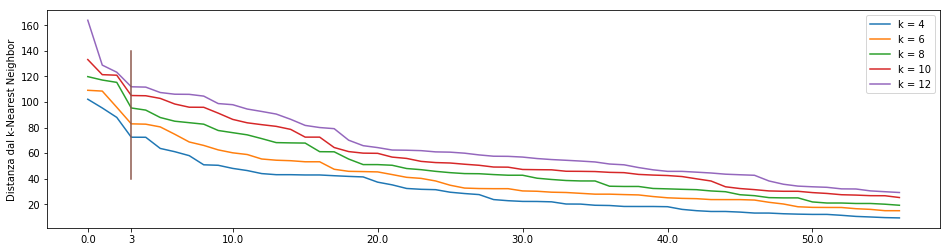

In [40]:
ks = range(4, 13, 2)
k_dists = np.zeros((np.shape(dist_matrix)[0], 1))

# plt.figure(figsize=(7,4))
for k in ks:
    for i in range(np.shape(dist_matrix)[0]):
        k_dists[i, :] = quickselect(dist_matrix[i], k)

    sorted_k_dists = sorted(k_dists, reverse=True)
    plt.plot(sorted_k_dists)
    
plt.ylabel('Distanza dal k-Nearest Neighbor')
plt.legend(['k = ' + str(k) for k in ks])

# Segno il punto di gomito nel grafico
ax = plt.gca()
xt = ax.get_xticks() 
xt = np.append(xt, 3)
xtl = xt.tolist()
xtl[-1] = "3"
ax.set_xticks(xt)
ax.set_xticklabels(xtl)

plt.plot(3*np.ones((57,)), np.linspace(40, 140, 57))

plt.show()

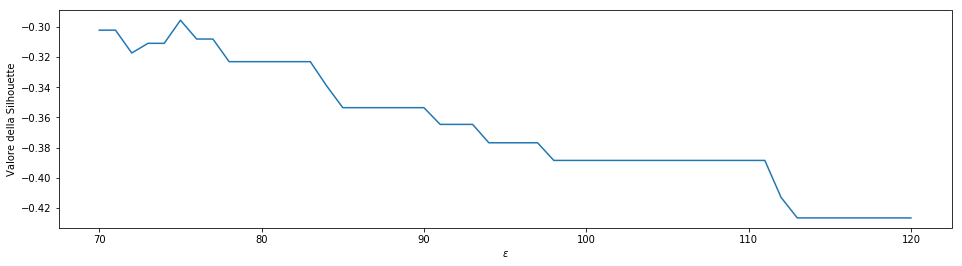

In [43]:
from scipy.stats import itemfreq
from sklearn.metrics import silhouette_score

epsilons = linspace(70, 120, 51)
sil_scores = []
for eps in epsilons:

    db = DBSCAN(eps=eps, min_samples=3, metric='precomputed').fit(dist_matrix)

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)

#     print('Number of clusters found: %d' % n_clusters_)
#     print itemfreq(db.labels_)
    
    sil = silhouette_score(padded_series.values(), db.labels_)
    sil_scores.append(sil)
    # cluster_sets = [ (l_,month_list[db.labels_ == l_]) for l_ in set(db.labels_) ]
    # for pp in cluster_sets:
    #     print pp[0], "\t--> ", list(pp[1])
    
plt.xlabel('$\epsilon$')
plt.ylabel('Valore della Silhouette')
plt.plot(epsilons, sil_scores)
plt.show()

In [ ]:
from scipy.stats import itemfreq
from sklearn.metrics import silhouette_score

epsilons = linspace(70, 120, 51)
sil_scores = []
for eps in epsilons:

    db = DBSCAN(eps=eps, min_samples=3, metric='precomputed').fit(dist_matrix)

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)

#     print('Number of clusters found: %d' % n_clusters_)
#     print itemfreq(db.labels_)
    
    sil = silhouette_score(padded_series.values(), db.labels_)
    sil_scores.append(sil)
    # cluster_sets = [ (l_,month_list[db.labels_ == l_]) for l_ in set(db.labels_) ]
    # for pp in cluster_sets:
    #     print pp[0], "\t--> ", list(pp[1])
    
plt.xlabel('$\epsilon$')
plt.ylabel('Valore della Silhouette')
plt.plot(epsilons, sil_scores)
plt.show()

### Clustering con K-means

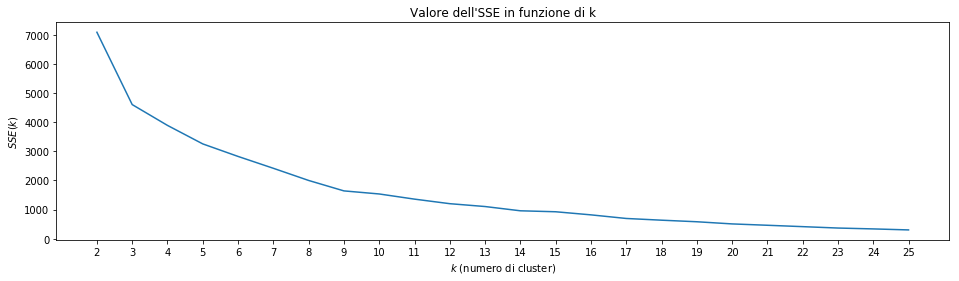

In [44]:
from sklearn.cluster import KMeans
import numpy as np

kmin = 2
kmax = 25
ks = range(kmin, kmax+1, 1)
SSEs = np.zeros((len(ks), 1))
for k in range(2, 26, 1):
    kmeans = KMeans(n_clusters=k).fit(padded_series.values())
    SSEs[k - kmin] = kmeans.inertia_
     
plt.plot(ks, SSEs)
plt.xlabel('$k$ (numero di cluster)')
plt.xticks(ks)
plt.ylabel('$SSE(k)$')
plt.title('Valore dell\'SSE in funzione di k')

plt.show()

In [45]:
kmeans = KMeans(n_clusters=3).fit(padded_series.values())
kmeans.labels_

array([0, 0, 2, 1, 1, 0, 1, 1, 1, 2, 2, 1, 0, 0, 1, 0, 1, 0, 0, 2, 0, 1, 0,
       0, 1, 1, 1, 1, 2, 0, 0, 1, 0, 2, 0, 0, 0, 1, 2, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 2, 2, 0, 1, 2, 1, 0], dtype=int32)

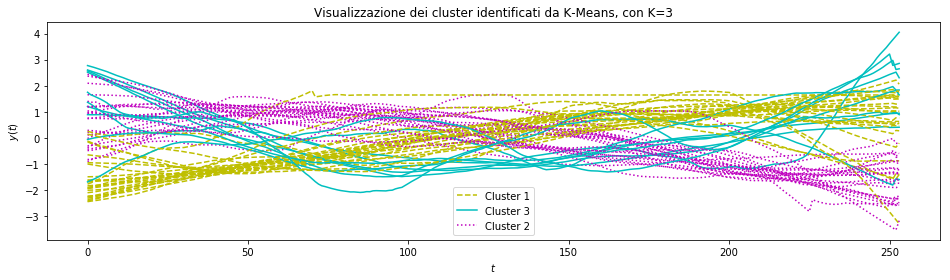

In [46]:
best_k = 3

# In linea di principio dovrei avere k colori, dove k è il numero di cluster scelti per K-Means
markers = ['y--', 'm:', 'c-', 'v-.', 'r', 'g', 'b']

ts = padded_series.values()
for i in range(len(ts)):
    line = plt.plot(ts[i], markers[kmeans.labels_[i]], label='Cluster %d' % (kmeans.labels_[i] + 1))
    
# Codice complicato per fare la legenda
from collections import OrderedDict
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.title('Visualizzazione dei cluster identificati da K-Means, con K=%d' % best_k)    
plt.xlabel('$t$')
plt.ylabel('$y(t)$')
plt.show()

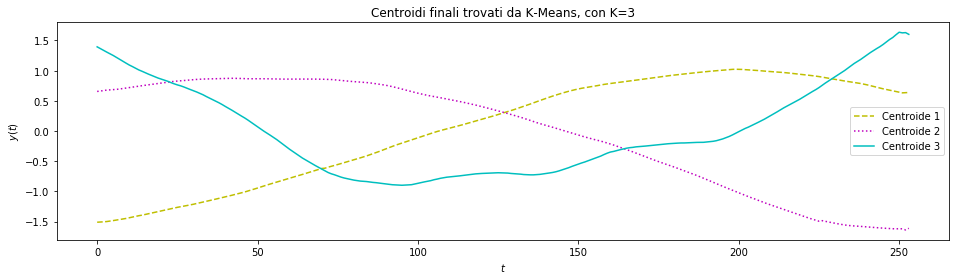

In [47]:
centroids = kmeans.cluster_centers_
for i, centroid in zip( range(best_k), centroids ):
    plt.plot(centroid, markers[i], label='Centroide %d' % (i+1))

plt.title('Centroidi finali trovati da K-Means, con K=%d' % best_k)
plt.xlabel('$t$')
plt.ylabel('$y(t)$')
plt.legend()
plt.show()

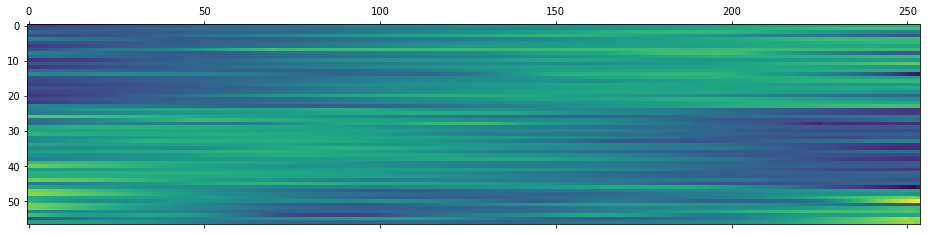

In [48]:
clusters_sizes = np.zeros((best_k,), dtype=int)
for cluster_label in kmeans.labels_:
    clusters_sizes[cluster_label] += 1
    
from operator import itemgetter
mm_sort = sorted( zip( padded_series.values(), kmeans.labels_ ), key=itemgetter(1) )
mm_sort = [el[0] for el in mm_sort]

# mat = []
# for i in range(1, best_k, 1):
#     if i < best_k:
#         portion = np.vstack((np.array(mm_sort[clusters_sizes[i-1] : clusters_sizes[i-1] + clusters_sizes[i]]), 
#                              np.zeros((1, 254)) - 5))
#         mat = portion if mat == [] else np.vstack((mat, portion))
        
# mat = np.vstack((mat, np.array(mm_sort[clusters_sizes[i-1] : clusters_sizes[i-1] + clusters_sizes[i]])))

# matshow(mat, interpolation=None, aspect='auto')
matshow(mm_sort, interpolation=None, aspect='auto')
plt.show()

### Clustering tramite feature-extraction (in particolare con la trasformata di Fourier)
-------------> Purtroppo non dà buoni risultati <-------------

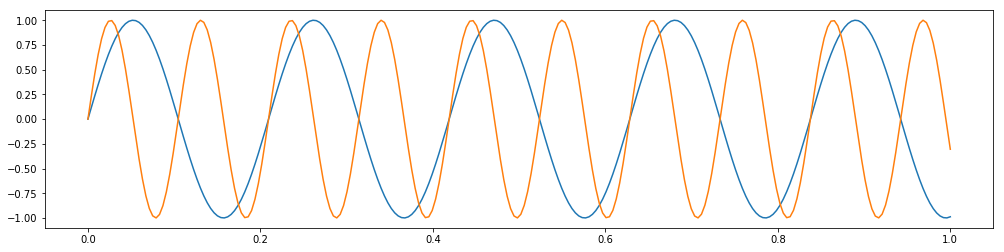

In [111]:
from scipy.signal import periodogram
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 1, 254)
t1 = np.sin( 30 * x )
t2 = np.sin( 60 * x )
t3 = np.random.uniform(low=-0.5, high=0.5,  size=(254,))

plt.figure(figsize=(17, 4))
plt.plot(x, t1)
plt.plot(x, t2)
plt.show()

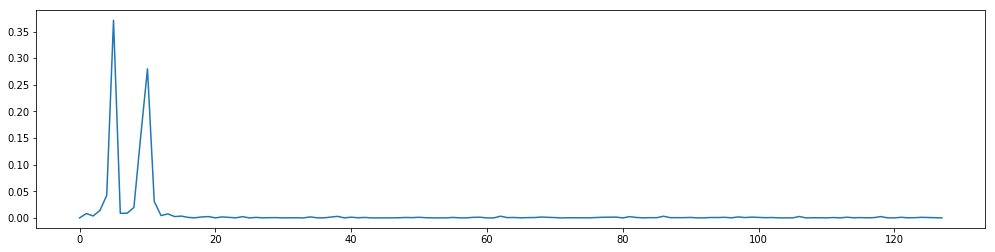

In [119]:
freqs, pow_spects = periodogram(t1 + t2 + t3, fs=254, scaling='spectrum')
#freqs, pow_spects = periodogram(t1, fs=254, scaling='spectrum')
#freqs, pow_spects = periodogram(t2, fs=254, scaling='spectrum')

plt.figure(figsize=(17, 4))
plt.plot(freqs, pow_spects)
#plt.plot(5*np.ones((100,)), np.linspace(0, 0.4, 100))

plt.show()

### Clustering feature-based con K-Means

In [135]:
power_spectrums = dict()
for key in padded_series:
    (_, power_spectrums[key]) = periodogram(padded_series[key], scaling='spectrum')

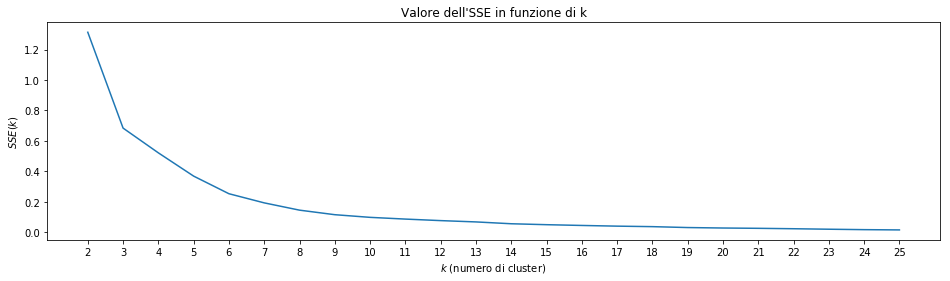

In [136]:
from sklearn.cluster import KMeans
import numpy as np

kmin = 2
kmax = 25
ks = range(kmin, kmax+1, 1)
SSEs = np.zeros((len(ks), 1))
for k in range(2, 26, 1):
    kmeans = KMeans(n_clusters=k).fit(power_spectrums.values())
    SSEs[k - kmin] = kmeans.inertia_
     
plt.plot(ks, SSEs)
plt.xlabel('$k$ (numero di cluster)')
plt.xticks(ks)
plt.ylabel('$SSE(k)$')
plt.title('Valore dell\'SSE in funzione di k')

plt.show()

In [145]:
best_k = 3
kmeans = KMeans(n_clusters=best_k).fit(power_spectrums.values())

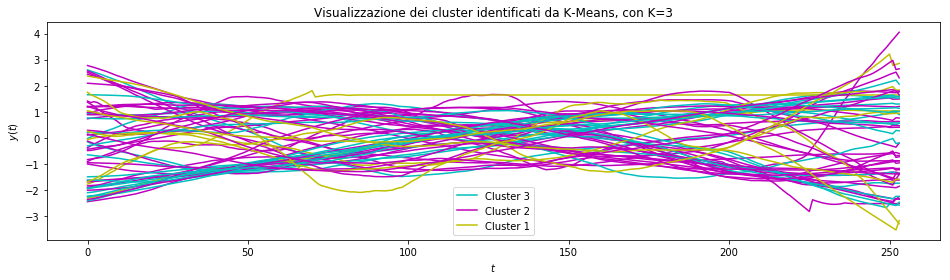

In [146]:
# In linea di principio dovrei avere k colori, dove k è il numero di cluster scelti per K-Means
markers = ['y', 'm', 'c', 'v', 'r', 'g', 'b']

ts = padded_series.values()
for i in range(len(ts)):
    line = plt.plot(ts[i], markers[kmeans.labels_[i]], label='Cluster %d' % (kmeans.labels_[i] + 1))
    
# Codice complicato per fare la legenda
from collections import OrderedDict
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.title('Visualizzazione dei cluster identificati da K-Means, con K=%d' % best_k)    
plt.xlabel('$t$')
plt.ylabel('$y(t)$')
plt.show()